In [3]:
import os
import glob
import numpy as np
import pickle

import constants as c

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from metrics import f1, recall, precision
from tensorflow.python.keras.losses import binary_crossentropy

import efn
from libs.efficientnet.efficientnet.tfkeras import preprocess_input

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from tqdm.notebook import tqdm
from collections import OrderedDict

import fnmatch
from collections import defaultdict

# Create curves!

In [4]:
def load_data(img_shape, data_path):
    datagenerator = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        #rotation_range=20,
        #horizontal_flip=True,
        #vertical_flip=True
    )

    return datagenerator.flow_from_directory(
        data_path,
        target_size=img_shape,
        batch_size=c.batch_size,
        classes=c.labels,
        color_mode='rgb',
        class_mode='binary',
        shuffle=False, # FALSE: Important for evaluation
        follow_links=True,
        seed=42)

In [25]:
def f1_score(precision, recall):
    return 2*precision*recall / (precision+recall)


def create_precision_recall_plots(model_name, y_true, y_pred, color):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred, pos_label=1, sample_weight=None)
    ap = round(average_precision_score(y_true, y_pred, pos_label=1, sample_weight=None)*100,1)

    best_x,best_y, best_f1, best_threshold = 0,0,0,0
    for p,r,t in zip(precisions, recalls, thresholds):
        f1 = f1_score(p, r)
        if f1 > best_f1:
            best_f1 = f1
            best_x = r
            best_y = p
            best_threshold = t

    label_text = f'{model_name} (AP: {ap}): F1 {round(best_f1, 2)} - Threshold {str(round(best_threshold,2))}'
    print(label_text)
    plt.plot(recalls, precisions, "-", best_x, best_y, "o", label=label_text, color=f"C{color}")
    #plt.plot(best_x, best_y, marker='o', label=f"F1: {round(best_f1,2)} - Threshold: {round(best_threshold,2)}")

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title(f'Precision-Recall Curve')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc="lower right")
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),
                loc='upper center', bbox_to_anchor=(0.5, -0.15),
                fancybox=True, shadow=True, ncol=1)

    plt.savefig(f"../visuals/efn/{model_name}-pr_curve.png", format='svg', dpi=300, bbox_inches='tight')

In [ ]:
phi = -5

model = efn.build_model(phi=-5, dropout=0)
img_shape = model.input_shape[1:3]
val_data = load_data(img_shape, c.val_dir)

amount_of_models_to_evaluate = len(glob.glob(f"{c.output_dir_models}/{phi}-*"))
with tqdm(total=amount_of_models_to_evaluate) as pbar:
    
    for efn_dir in glob.glob(f"{c.output_dir_models}/{phi}-*"):
        config = efn_dir.split('/')[-1].split('-')[-1].title()
        config = config.replace('Up1', 'Upsampled')
        print(f"Evaluating {config}...")

        # get latest checkpoint by time
        latest_checkpoint = max(glob.iglob(efn_dir+"/checkpoints/*"), key=os.path.getctime)
        model.load_weights(latest_checkpoint)

        y_pred = model.predict_generator(val_data)
        
        with open(f"{c.output_dir_models}/{config}_val_pred.pickle", 'wb') as handle:
            pickle.dump(y_pred, handle, protocol=4)
        
        pbar.update()

In [ ]:
img_shape = (113,113)
val_data = load_data(img_shape, c.val_dir)
num = 0

for config in sorted(glob.glob(f"{c.output_dir_models}/*.pickle")):
    with open(config, 'rb') as handle:
        y_pred = pickle.load(handle)
        config = os.path.basename(config).split('_')[:-2]
        config_name = ' '.join(config).replace("-", " - ").title()

        create_precision_recall_plots(config_name, val_data.labels, y_pred, num)
        num +=1

## only $dropout=0.15$

In [ ]:
def create_precision_recall_plots2(model_name, y_true, y_pred, color):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred, pos_label=1, sample_weight=None)
    ap = round(average_precision_score(y_true, y_pred, pos_label=1, sample_weight=None)*100,2)

    best_x,best_y, best_f1, best_threshold = 0,0,0,0
    for p,r,t in zip(precisions, recalls, thresholds):
        f1 = f1_score(p, r)
        if f1 > best_f1:
            best_f1 = f1
            best_x = r
            best_y = p
            best_threshold = t

    label_text = f'{model_name} (AP: {ap}) - F1 {round(best_f1, 3)} @ Threshold {str(round(best_threshold,3))}'
    print(label_text)
    plt.plot(recalls, precisions, "-", best_x, best_y, "o", label=label_text, color=f"C{color}", lw=1)
    #plt.plot(recalls, precisions, "-", label=label_text, color=f"C{color}", lw=2)
    #plt.plot(best_x, best_y, marker='o', label=f"F1: {round(best_f1,2)} - Threshold: {round(best_threshold,2)}")

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    #plt.title(f'Precision-Recall Curve')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc="lower right")
    plt.xlim([0.0, 1.05])
    plt.ylim([0.85, 1.02])
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),
                loc='upper center', bbox_to_anchor=(0.5, -0.15),
                fancybox=True, shadow=True, ncol=1)

    plt.savefig(f"../visuals/efn/efnN5-pr_curve2.png", format='png', dpi=300, bbox_inches='tight')

Found 3412 images belonging to 2 classes.
Default (AP: 92.6): F1 0.86 - Threshold 0.25
Upsampled (AP: 88.5): F1 0.85 - Threshold 0.74
Weighted (AP: 84.5): F1 0.83 - Threshold 0.77


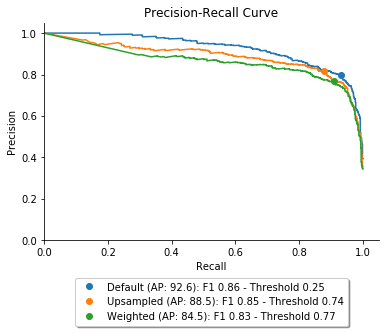

In [27]:
img_shape = (113,113)
val_data = load_data(img_shape, c.val_dir)
num = 0

for config in sorted(glob.glob(f"{c.output_dir_models}/dropout_0.15*.pickle")):
    with open(config, 'rb') as handle:
        y_pred = pickle.load(handle)
        config = os.path.basename(config)[13:].split('_')[:-2]
        config_name = ' '.join(config).replace("-", " - ").title()

        create_precision_recall_plots2(config_name, val_data.labels, y_pred, num)
        num +=1

# Evaluate smaller `EFN`

In [ ]:
amount_of_models_to_evaluate = len(glob.glob(f"{c.output_dir}/efn_scale/*-weighted/"))
with tqdm(total=amount_of_models_to_evaluate) as pbar:
    for checkpoints in sorted(glob.glob(f"../output/efn_scale/*/checkpoints/")):
        phi = -int(checkpoints.split('/')[3].split('-')[1]) # get phi by dirname
        if phi > -6: continue

        model = efn.build_model(phi=phi, dropout=0.15)
        model_checkpoints = f"{checkpoints}/*.hdf5"
        latest_checkpoint = max(glob.iglob(model_checkpoints), key=os.path.getctime)
        model.load_weights(latest_checkpoint)
        #model.summary()

        img_shape = model.input_shape[1:3]
        val_data = load_data(img_shape, c.val_dir)

        print(f"Evaluating {phi}...")
        y_pred = model.predict_generator(val_data)

        with open(f"{c.output_dir}/efn_scale/{phi}_val_pred.pickle", 'wb') as handle:
            pickle.dump(y_pred, handle, protocol=4)

        pbar.update()

In [ ]:
def f1_score(precision, recall):
    return 2*precision*recall / (precision+recall)

def create_precision_recall_plots3(model_name, y_true, y_pred, color):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred, pos_label=1, sample_weight=None)
    ap = round(average_precision_score(y_true, y_pred, pos_label=1, sample_weight=None)*100,1)

    best_x,best_y, best_f1, best_threshold = 0,0,0,0
    for p,r,t in zip(precisions, recalls, thresholds):
        f1 = f1_score(p, r)
        if f1 > best_f1:
            best_f1 = f1
            best_x = r
            best_y = p
            best_threshold = t

    label_text = fr'$\phi={model_name}$: AP={ap}, F1={round(best_f1, 2)}'
    print(label_text, best_x, best_y, best_threshold)
    plt.plot(recalls, precisions, "-", best_x, best_y, "o", label=label_text, color=f"C{color}", lw=1)
    #plt.plot(recalls, precisions, "-", label=label_text, color=f"C{color}", lw=2)
    #plt.plot(best_x, best_y, marker='o', label=f"F1: {round(best_f1,2)} - Threshold: {round(best_threshold,2)}")

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    #plt.title(f'Precision-Recall Curve')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc="lower right")
    plt.xlim([0.0, 1.05])
    plt.ylim([0.85, 1.02])
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),
                loc='upper center', bbox_to_anchor=(0.5, -0.15),
                fancybox=True, shadow=True, ncol=3)

    plt.savefig(f"../visuals/efn/efn_scaled-pr_curve.png", format='png', dpi=300, bbox_inches='tight')

In [ ]:
img_shape = (113,113)
val_data = load_data(img_shape, c.val_dir)
num = 0

for phi in np.linspace(-5, -15, 11, dtype=int):
    predictions = glob.glob(f"{c.output_dir}/efn_scale/{phi}*.pickle")[0]
    with open(predictions, 'rb') as handle:
        y_pred = pickle.load(handle)
        
        phi = int(predictions.split('/')[3].split('_')[0]) # get phi by dirname
        
        create_precision_recall_plots3(phi, val_data.labels, y_pred, num)
        num +=1